In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from copy import deepcopy

import gamspec

In [15]:
test = gamspec.Spectrum.from_MCNP(r'E:\Gamut_dev\spectrum_analysis\模拟Eu152能谱2\Eu152sgl_benchmark_1.08591.out')

In [22]:
gamspec.GaussPeakSearcher(2, 0.3)(test).peaks

[{'location': 1029},
 {'location': 1980},
 {'location': 3583},
 {'location': 3705}]

In [23]:
gamspec.AverageAreaCalculator(5)(gamspec.GaussPeakSearcher(2, 0.3)(test)).export_to_pandas()

,left,right,energy,location,area
0,1027,1031,301.678796,1029,19.7
1,1978,1983,580.489791,1980,25.6
2,3580,3586,1050.451961,3583,30.6
3,3687,3722,1086.219512,3705,30972.6


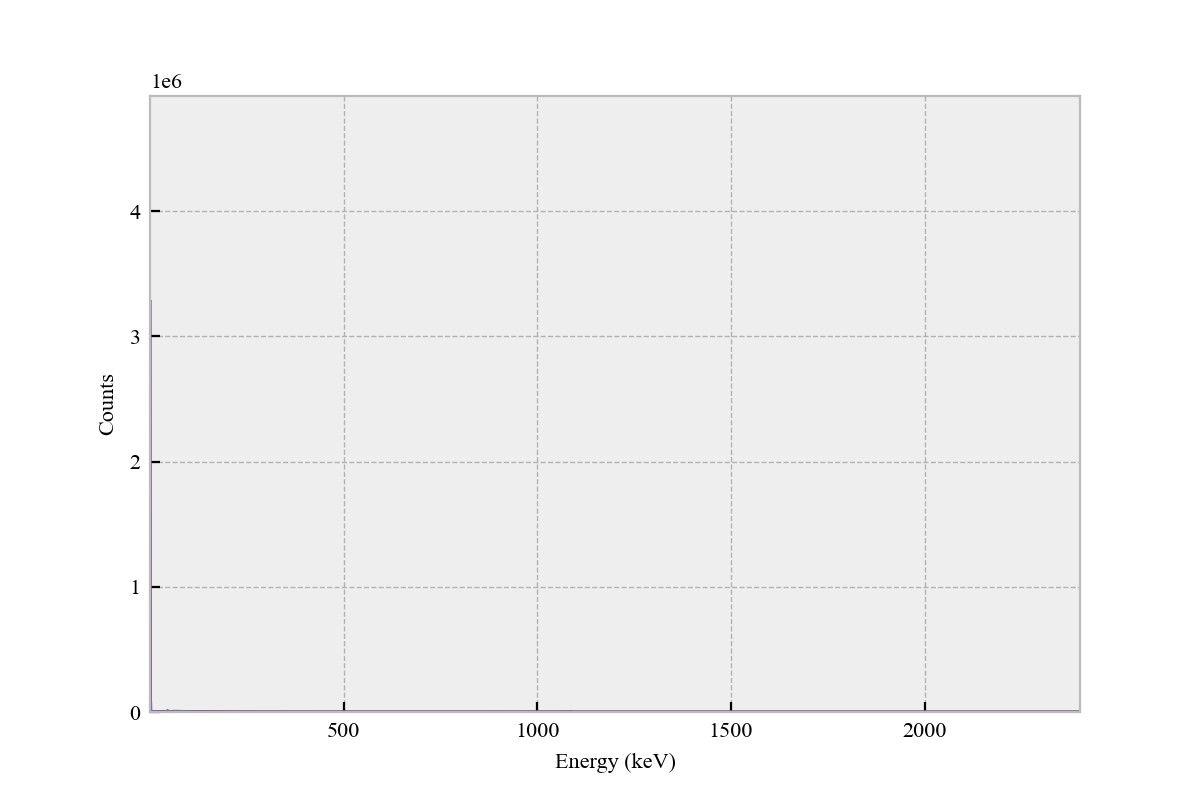

In [17]:
test.plot()
plt.show()

然后，我们希望导入预定义的管道网（分析流程）。

In [3]:
# 用于寻峰的分支
sav = gamspec.SavitzkySmoother(3, 3)
convol = gamspec.SecondConvolutionPeakSearcher()
# peakfilter = gamspec.PeakSearcher()
fpeak = gamspec.Flow(gamspec.Pipe([sav, convol]), 0, 0, 1, 0)

# 用于平滑的分支
wavelet = gamspec.TranslationInvarianceWaveletSmoother('dmey', 'quadratic-soft', order=3)
# wavelet = gamspec.SavitzkySmoother(3, 4)
fsmooth = gamspec.Flow(wavelet, 0, 0, 1, 1) 

# 两个分支合并
def combine(spec1, spec2):
    spec2.regions = deepcopy(spec1.regions)
    return spec2
comb = gamspec.Combinor(2, func=combine)
fcomb = gamspec.Flow(comb, 1, [0, 1], 2, 0)

# 剥谱
strp = gamspec.OtherOperator.AdaptiveSNIPStripper(baseline=False)
fstrip = gamspec.Flow(strp, 2, 0, 3, 0)

# 拟合，计算峰面积
fit = gamspec.RegionPeakFitter(10, equal_width=False, baseline=False)
ffit = gamspec.Flow(fit, 3, 0, 4, 0)

pipenet = gamspec.PipeNet([fpeak, fsmooth, fcomb, fstrip, ffit])

In [4]:
'''
Author: albertzhang albert.zhangweij@outlook.com
Date: 2024-01-17 12:03:17
Description: 

Copyright (c) 2024 by THU-RSAG, All Rights Reserved. 
'''

# 用于寻峰的分支
sav = gamspec.SavitzkySmoother(3, 3)
convol = gamspec.SecondConvolutionPeakSearcher()
fpeak = gamspec.Flow(gamspec.Pipe([sav, convol]), 0, 0, 1, 0)

# 用于平滑的分支
wavelet = gamspec.TranslationInvarianceWaveletSmoother('dmey', 'quadratic-soft', order=3)
# wavelet = sav
# wavelet = gamspec.Passer()
fsmooth = gamspec.Flow(wavelet, 0, 0, 1, 1) 

# 两个分支合并
def combine(spec1, spec2):
    spec2.regions = deepcopy(spec1.regions)
    return spec2
comb = gamspec.Combinor(2, func=combine)
fcomb = gamspec.Flow(comb, 1, [0, 1], 2, 0)

# 剥谱
strp = gamspec.OtherOperator.AdaptiveSNIPStripper(baseline=False)
fstrip = gamspec.Flow(strp, 2, 0, 3, 0)

# 拟合，计算峰面积
fit = gamspec.RegionPeakFitter(3, equal_width=False, baseline=False)
ffit = gamspec.Flow(fit, 3, 0, 4, 0)

pipenet = gamspec.PipeNet([fpeak, fsmooth, fcomb, fstrip, ffit])

In [13]:
import pathlib
from re import match

results_combined = []
files = pathlib.Path(r'E:\Gamut_dev\spectrum_analysis\模拟Eu152能谱2\\').glob("Eu152sgl_benchmark_*.out")
for file in files:
    energy = match(r'Eu152sgl_benchmark_(\d+\.\d+).out', file.name).group(1)
    energy = float(energy) 

    if pathlib.Path(file.stem+'.xlsx').exists():
        print("read existing file:" + file.stem+'.xlsx')
        df = pd.read_excel(file.stem+'.xlsx')
    else:
        print("read new file:" + str(file))
        spectrum = gamspec.Spectrum.from_MCNP(str(file))
        pipenet([spectrum])
        spec = pipenet.get_node(4)[0]
        spec.export_to_xml(file.stem+'.xml')
        df = spec.export_to_pandas()
        df.to_excel(file.stem+'.xlsx')

    aim = df[(df['energy'] - energy*1000).abs()<2]
    aim['set_energy'] = energy
    results_combined.append(aim)

read existing file:Eu152sgl_benchmark_0.03952.xlsx
read existing file:Eu152sgl_benchmark_0.04012.xlsx
read existing file:Eu152sgl_benchmark_0.0454.xlsx
read existing file:Eu152sgl_benchmark_0.12178.xlsx
read existing file:Eu152sgl_benchmark_0.2447.xlsx
read existing file:Eu152sgl_benchmark_0.34428.xlsx
read existing file:Eu152sgl_benchmark_0.36779.xlsx
read existing file:Eu152sgl_benchmark_0.41111.xlsx
read existing file:Eu152sgl_benchmark_0.44398.xlsx
read existing file:Eu152sgl_benchmark_0.68868.xlsx
read existing file:Eu152sgl_benchmark_0.7789.xlsx
read existing file:Eu152sgl_benchmark_0.86739.xlsx
read existing file:Eu152sgl_benchmark_0.96413.xlsx
read existing file:Eu152sgl_benchmark_1.08591.xlsx
read existing file:Eu152sgl_benchmark_1.0897.xlsx
read new file:E:\Gamut_dev\spectrum_analysis\模拟Eu152能谱2\Eu152sgl_benchmark_1.11212.out
GAMUT: Start running PipeNet
|Execute: Node 0|[0] >> SavitzkySmoother[O3W7]>>SecondConvolutionSearcher[F10] >> Node 1|[0]


C:\Users\alber\AppData\Local\Temp\ipykernel_29520\1446033892.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aim['set_energy'] = energy
C:\Users\alber\AppData\Local\Temp\ipykernel_29520\1446033892.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aim['set_energy'] = energy
C:\Users\alber\AppData\Local\Temp\ipykernel_29520\1446033892.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

|Execute: Node 0|[0] >> TIWaveletSmoother[O3MqTv] >> Node 1|[1]
|Execute: Node 1|[0, 1] >> Combinor >> Node 2|[0]
|Execute: Node 2|[0] >> AdaptiveSNIPStripper >> Node 5|[1]
|Execute: Node 2|[0] >> CovarianceSearcher[F4] >> Node 5|[0]


KeyboardInterrupt: 

In [ ]:
energies = np.array([40.12, 45.40, 121.78, 244.70, 344.28, 367.79, 411.11, 443.98, 688.68, 778.90, 867.39, 964.13, 1085.91, 1089.70, 1112.12, 1212.95, 1299.12])
def energy_in_group(energy):
    return np.any(np.abs(energy-energies)<2)
energy_in_group(50)

False

In [ ]:
df

,Unnamed: 0,left,right,energy,location,height,stderr,area,err_area,fitness
0,0,90,110,31.076748,106,460.053152,1.105375,1.274698e+03,4.062337e+01,0.960318
1,1,412,471,124.013746,423,31.343506,95.029722,7.466154e+03,2.795045e+06,0.002884
2,2,587,618,180.890016,617,39.970952,12.316470,1.234016e+03,5.289546e+03,0.272038
3,3,649,660,191.737553,654,45.178705,2.729519,3.091078e+02,1.330519e+02,0.281270
4,4,720,831,218.416628,745,248.574251,13.460164,8.386803e+03,1.874070e+03,0.819426
5,5,720,831,228.970987,781,116.421729,31.055081,9.062680e+03,5.648076e+03,0.819426
6,6,1081,1135,323.373868,1103,25.720222,58.892711,3.796874e+03,3.329165e+05,0.002164
7,7,1142,1163,337.153171,1150,44.551699,5.804007,6.481598e+02,3.522702e+02,0.111985
8,8,1286,1310,380.543315,1298,34.850077,6.995824,6.111285e+02,2.765608e+02,0.316857
9,9,1435,1446,422.174400,1440,41.355480,4.280146,4.436920e+02,8.397003e+02,0.084253


In [ ]:
results = pd.concat(results_combined)
results

,Unnamed: 0,left,right,energy,location,height,stderr,area,err_area,fitness,set_energy
1,1,127,141,39.578871,135,7.396370e+04,0.673624,1.248896e+05,363.551630,0.981223,0.03952
1,1,127,144,40.165224,137,7.784610e+04,0.668821,1.305079e+05,370.239713,0.984631,0.04012
1,1,128,170,45.442404,155,1.242521e+05,0.594804,1.852540e+05,434.066742,0.989460,0.04540
2,2,263,463,121.961510,416,1.371121e+06,0.617644,2.122774e+06,1475.775115,0.999396,0.12178
3,3,830,840,244.802526,835,1.151849e+06,1.552823,4.483398e+06,2920.994343,0.999961,0.24470
2,2,1167,1182,344.482587,1175,9.766290e+05,2.112224,5.170821e+06,2931.059831,0.999973,0.34428
3,3,1247,1263,367.936719,1255,9.458234e+05,2.228369,5.283079e+06,2931.011048,0.999981,0.36779
7,7,1319,1434,411.326864,1403,8.978281e+05,2.426410,5.460688e+06,2435.879134,0.999962,0.41111
5,5,1393,1558,444.162648,1515,8.671339e+05,2.565427,5.576167e+06,2451.949591,0.999953,0.44398
7,7,2274,2382,688.965151,2350,7.279792e+05,3.354672,6.121515e+06,2596.585477,0.999979,0.68868


In [ ]:
results_combined[5]

,Unnamed: 0,left,right,energy,location,height,stderr,area,err_area,fitness,set_energy
2,2,1167,1182,344.482587,1175,976628.961875,2.112224,5.170821e+06,2931.059831,0.999973,0.34428


In [ ]:
# %matplotlib widget
plt.close()
pipenet.get_node(0)[0].plot()
spec = pipenet.get_node(5)[0]
spec.plot()
spec.plot_regions()
# spec.plot_peaks()
# plt.xlim(0, 50)
plt.show()

AttributeError: 'NoneType' object has no attribute 'plot'